In [1]:
# Required Libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
# Download NLTK Resources
import nltk

In [12]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    # turn lowercase
    text = text.lower()
    return text.strip()

In [13]:
from datetime import datetime  # Add this line to import datetime

# Load the posts and comments from JSONL files
def load_jsonl(file_path, text_fields):
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]
    rows = []
    for item in data:
        if any(item.get(field, '') in ['[removed]', '[deleted]'] for field in text_fields):
            continue
        text = ' '.join(item.get(field, '') for field in text_fields)
        timestamp = item.get('created_utc')
        if text and timestamp:
            dt = datetime.utcfromtimestamp(timestamp)
            # convert to day format (YYYY-MM-DD)
            day = dt.strftime('%Y-%m-%d')
            # convert to month format (YYYY-MM)
            # month = dt.strftime('%Y-%m')
            # week = dt.strftime('%Y-%U')  # Convert to week format (year-week)
            rows.append((day, clean_text(text)))
    return rows

In [ ]:
import pandas as pd
import re


posts = load_jsonl('../2_months_data/filtered_posts.jsonl', ['title', 'selftext'])
comments = load_jsonl('../2_months_data/filtered_comments.jsonl', ['body'])

# Combine posts and comments into a single DataFrame
df_posts = pd.DataFrame(posts, columns=['day', 'text'])
df_comments = pd.DataFrame(comments, columns=['day', 'text'])
df = pd.concat([df_posts, df_comments], axis=0)

/tmp/ipykernel_3417441/1179890811.py:14: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt = datetime.utcfromtimestamp(timestamp)


In [15]:
df.describe()

,day,text
count,774173,774173
unique,58,719652
top,2025-01-29,
freq,36133,10478


In [16]:
telework_keywords = [
    "telework", "remote work", "wfh", "work from home", 
    "telecommute", "hybrid work", "office policy", 
    "rto", "WFH", "telework", "from home", "remote",
]
# Escape spaces in multi-word keywords and wrap in word boundaries
processed_keywords = []
for keyword in telework_keywords:
    if ' ' in keyword:
        # Replace spaces with \s+ (matches any whitespace) and wrap in \b
        processed = r'\b' + r'\s+'.join(keyword.split()) + r'\b'
    else:
        processed = r'\b' + keyword + r'\b'
    processed_keywords.append(processed)

# Build the regex pattern
pattern = r'(?:{})'.format('|'.join(processed_keywords))

In [19]:
def is_telework(text):
    # Use the processed regex pattern
    return bool(re.search(pattern, str(text), flags=re.IGNORECASE))

df_telework = df[df['text'].apply(is_telework)].copy()

In [20]:
df_telework.describe()

,day,text
count,27056,27056
unique,58,26887
top,2025-01-24,boycott the restaurants bars coffee shops and ...
freq,2010,11


In [23]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the required resource
nltk.download('vader_lexicon')

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df_telework['sentiment'] = df_telework['text'].apply(
    lambda x: sia.polarity_scores(x)['compound']  # Compound score (-1 to 1)
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/csgrads/shahr072/nltk_data...


In [25]:
from transformers import pipeline

classifier = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion")
df_telework['emotion'] = df_telework['text'].apply(
    lambda x: classifier(x, truncation=True)[0]['label']
)

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
# Save the DataFrame to a CSV file 
df_telework.to_csv('telework_' \
'comments.csv', index=False)

In [27]:
df_telework.head()

,day,text,sentiment,emotion
0,2025-01-01,connecticut feds which health insurance did yo...,0.7579,joy
3,2025-01-01,vha vs gsa for remote employees i am currently...,0.4510,joy
10,2025-01-01,eap help for personal issue dod i am not 100 h...,-0.9354,anger
11,2025-01-01,department of state 2 days per pay period tele...,-0.2023,joy
16,2025-01-01,hybrid telework do you stick to a regular mor...,-0.2960,joy


Visualizing the sentiment from csv file

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#../2_months_data/filtered_posts.jsonl
# Load your CSV
df = pd.read_csv("../notebooks/telework_related_posts_comments.csv", parse_dates=["day"])

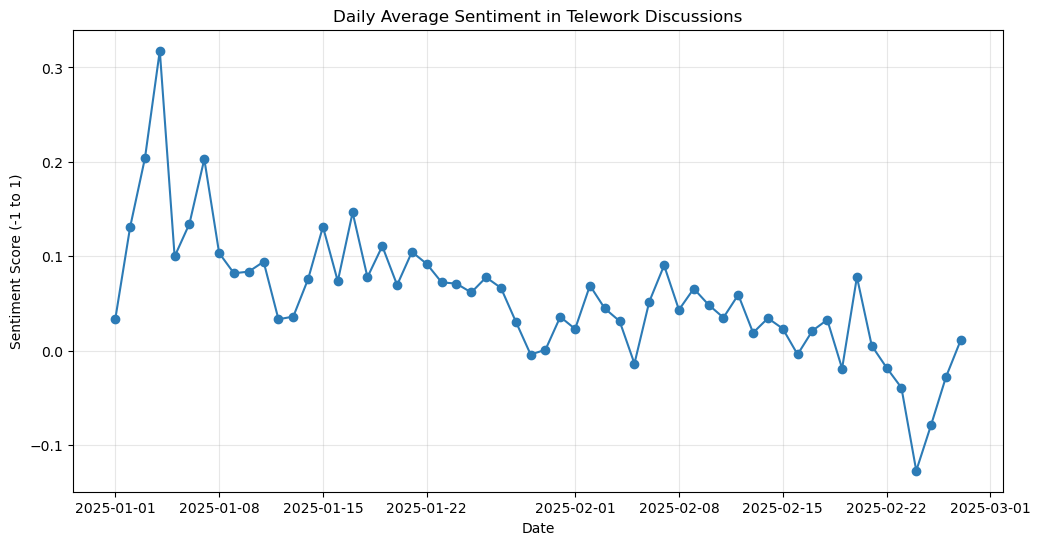

In [30]:
# Group by day and calculate mean sentiment
daily_sentiment = df.groupby("day")["sentiment"].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment["day"], daily_sentiment["sentiment"], marker="o", color="#2c7bb6")
plt.title("Daily Average Sentiment in Telework Discussions")
plt.xlabel("Date")
plt.ylabel("Sentiment Score (-1 to 1)")
plt.grid(True, alpha=0.3)
plt.show()

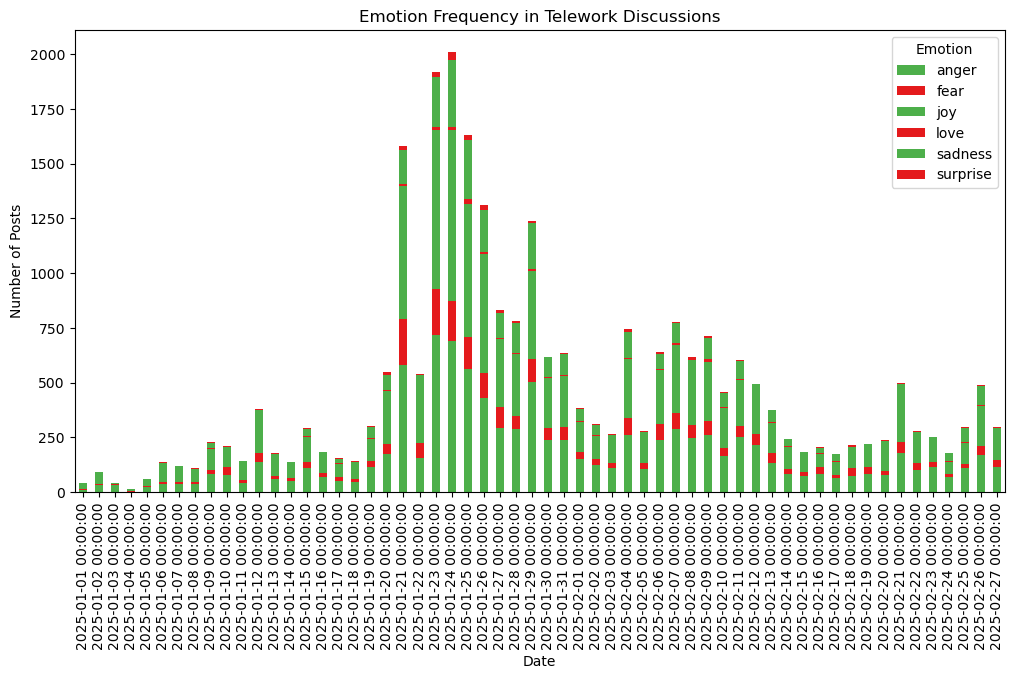

In [31]:
# Count emotions per day
emotion_counts = df.groupby(["day", "emotion"]).size().unstack().fillna(0)

# Plot
emotion_counts.plot(kind="bar", stacked=True, figsize=(12, 6), color=["#4daf4a", "#e41a1c"])
plt.title("Emotion Frequency in Telework Discussions")
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.legend(title="Emotion")
plt.show()

/tmp/ipykernel_3417441/3869586957.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="emotion", y="sentiment", palette=["#4daf4a", "#e41a1c"])
/tmp/ipykernel_3417441/3869586957.py:2: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df, x="emotion", y="sentiment", palette=["#4daf4a", "#e41a1c"])


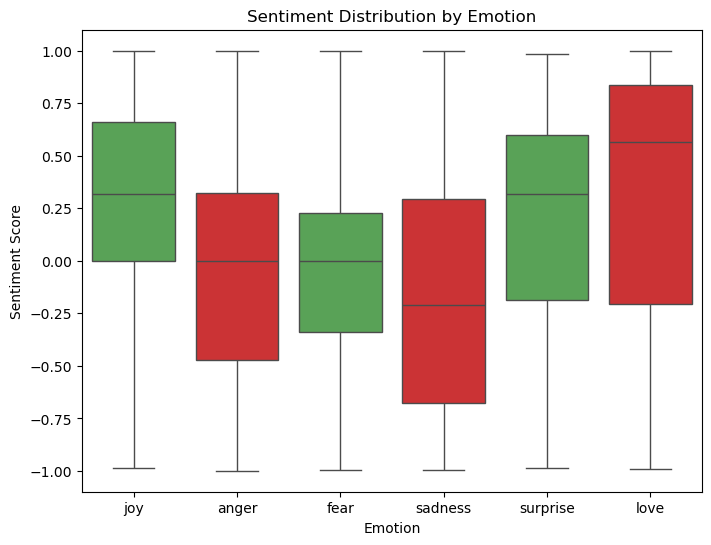

In [32]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="emotion", y="sentiment", palette=["#4daf4a", "#e41a1c"])
plt.title("Sentiment Distribution by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Sentiment Score")
plt.show()

/tmp/ipykernel_3417441/2160468848.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df,


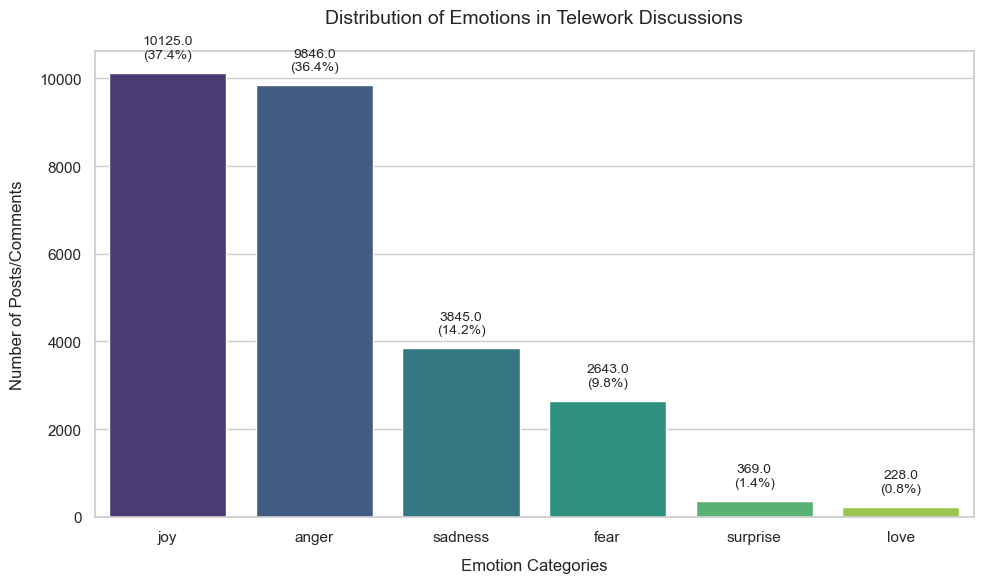

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better aesthetics
sns.set(style="whitegrid")

# Count emotions and create plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, 
                   x='emotion', 
                   order=df_telework['emotion'].value_counts().index,
                   palette="viridis")

# Add annotations and labels
plt.title('Distribution of Emotions in Telework Discussions', pad=20, fontsize=14)
plt.xlabel('Emotion Categories', labelpad=10)
plt.ylabel('Number of Posts/Comments', labelpad=10)

# Add percentage labels on top of each bar
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.01*total,
            f'{height}\n({height/total:.1%})',
            ha='center', 
            va='bottom',
            fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()

Sentiment Trend Over Time

Hypotheses:
Null (H₀): No correlation between time and sentiment.
Alternative (H₁): Sentiment changes over time.

If p < 0.05: Reject H₀. Sentiment correlates with time.
Correlation Value:
> 0: Positive trend (sentiment improves over time).

< 0: Negative trend (sentiment worsens over time).

In [35]:
import pandas as pd
import scipy.stats as stats

# Convert dates to ordinal numbers (e.g., day 1, day 2)
df["day_ordinal"] = df["day"].apply(lambda x: x.toordinal())

# Pearson correlation (assumes linearity)
corr, p_corr = stats.pearsonr(df["day_ordinal"], df["sentiment"])

print("\nTest 2: Pearson Correlation")
print(f"Correlation: {corr:.4f}\nP-value: {p_corr:.4f}")


Test 2: Pearson Correlation
Correlation: -0.0559
P-value: 0.0000


Test 3: Emotion Frequency Over Time (Chi-Square)
Hypotheses:
Null (H₀): Emotion distribution is constant over days.

Alternative (H₁): Emotion proportions change over time.

If p < 0.05: Reject H₀. Emotion distribution changes over days.

In [36]:
# Create a contingency table (days vs. emotions)
contingency = pd.crosstab(df["day"], df["emotion"])

# Chi-square test
chi2, p_chi, dof, _ = stats.chi2_contingency(contingency)

print("\nTest 3: Chi-Square Test")
print(f"Chi2: {chi2:.4f}\nP-value: {p_chi:.4f}")


Test 3: Chi-Square Test
Chi2: 510.8719
P-value: 0.0000
